# Rock-Paper-Scissor Self Play

In [13]:
import sys 
sys.path.append("../src")
import numpy
import matplotlib.pyplot as plt
import LearningGames

## Create game

In [14]:
class RPS_selfplay:
    action_set={"R","P","S"}
    def __init__(self,length_measurement=1):
        """Create game

        Args:
            length_measurement (int): number of actions of other player to be used as measurement
        """
        self.length_measurement=length_measurement
        if length_measurement>0:
            # create outputs with all combinations of actions
            measurement_set=self.action_set
            for i in range(length_measurement-1):
                new_measurement_set=set()
                for m in measurement_set:
                    for a in self.action_set:
                        new_measurement_set.add(m+a)
                measurement_set=new_measurement_set
            print("Measurement set with {:d} elements".format(len(measurement_set)))
            if len(measurement_set)<28:
                print(measurement_set)
            self.measurement_set=measurement_set
            # initialize measurement
            self.measurement4player1=length_measurement*"S"
            self.measurement4player2=length_measurement*"S"
        else:
            self.measurement_set=[None]
            self.measurement4player1=None
            self.measurement4player2=None
    def cost(self,player1_action,player2_action) -> float:
        """Returns game outcome

        Args:
            player1_action: action for player 1
            player2_action: action for player 2

        Returns:
            game result (float): -1 if player 1 wins, +1 if player 1 loses, 0 draw
        """
        if player1_action==player2_action:
            # draw
            return 0
        if (player1_action=="R" and player2_action=="S") or (player1_action=="P" and player2_action=="R") or (player1_action=="S" and player2_action=="P"):
            return -1
        else:
            return +1                
    def get_measurement(self):
        """get measurement for next game

        Returns: tuple[str,str]
            measurement4player1: measurement for player 1 for the next game
            measurement4player2: measurement for player 2 for the next game
        """
        return (self.measurement4player1,self.measurement4player2)
    def play(self,player1_action,player2_action) -> tuple[float,dict[str,float],dict[str,float]]:      
        """Play game

        Args:
            player1_action: action for player 1
            player2_action: action for player 2

        Returns: 
            tuple[float,dict(str,float)]
            cost (float): -1 if player 1 wins, +1 if player 1 loses, 0 draw
            all_costs4player1 (dict[str,float]): dictionary with costs for all actions of player 1
            all_costs4player2 (dict[str,float]): dictionary with costs for all actions of player 2
        """
        # update measurement
        if self.length_measurement>0:
            self.measurement4player1=self.measurement4player1[1:]+player2_action
            self.measurement4player2=self.measurement4player2[1:]+player1_action
        # cost for given action of player 1
        cost=self.cost(player1_action,player2_action)
        # costs for all actions of player 1
        all_costs4player1={a:self.cost(a,player2_action) for a in self.action_set}
        all_costs4player2={a:-self.cost(player1_action,a) for a in self.action_set}  # flip sign of costs for player 2 (to minimize)
        return (cost,all_costs4player1,all_costs4player2)
    

## Create Game and LearningGame objects

+ Against a static player, we can use `gamma=0`
+ Against a deterministic player, the temperature can be quite low. This will result in very fast learning.

In [31]:
game=RPS_selfplay(length_measurement=1)
lg1=LearningGames.LearningGame(game.action_set,measurement_set=game.measurement_set,
                               gamma=0.0,inverse_temperature=.01,seed=0);
lg2=LearningGames.LearningGame(game.action_set,measurement_set=game.measurement_set,
                               gamma=0.0,inverse_temperature=.01,seed=1);

Measurement set with 3 elements
{'S', 'R', 'P'}


## Simulate game

In [34]:
lg1.reset()
lg2.reset()
M = 10000
costs=numpy.zeros(M)
player1_entropy=numpy.zeros(M)
player2_entropy=numpy.zeros(M)
player1_action=M*["-"]
player2_action=M*["-"]
for iter in range(M):
    # Play
    (measurement4player1,measurement4player2)=game.get_measurement()
    (player1_action[iter],_,player1_entropy[iter])=lg1.get_action(measurement4player1)
    (player2_action[iter],_,player2_entropy[iter])=lg2.get_action(measurement4player2)
    (costs[iter],all_costs4player1,all_costs4player2)=game.play(player1_action[iter],player2_action[iter])
    # Learn
    lg1.update_energies(measurement4player1, all_costs4player1)
    lg2.update_energies(measurement4player2, all_costs4player2)
    # output
    if iter<10:
        print("iter={:4d}, measurement4player1 = {:s}, player1_action = {:s}, measurement4player2 = {:s}, player2_action = {:s}, cost = {:2.0f}, all_costs4player1 = {:s}, all_costs4player2 = {:s}".format(
            iter,str(measurement4player1),player1_action[iter],
            str(measurement4player2),player2_action[iter],
            costs[iter],str(all_costs4player1),str(all_costs4player2)))
    #print(lg.energy)
print("Regret for player 1:")
lg1.get_regret(display=True);
print(lg1.energy)
print(player1_action[-20:])
print("Regret for player 2:")
lg2.get_regret(display=True);
print(lg2.energy)
print(player2_action[-20:])


iter=   0, measurement4player1 = S, player1_action = P, measurement4player2 = S, player2_action = R, cost = -1, all_costs4player1 = {'S': 1, 'R': 0, 'P': -1}, all_costs4player2 = {'S': -1, 'R': 1, 'P': 0}
iter=   1, measurement4player1 = R, player1_action = R, measurement4player2 = P, player2_action = R, cost =  0, all_costs4player1 = {'S': 1, 'R': 0, 'P': -1}, all_costs4player2 = {'S': 1, 'R': 0, 'P': -1}
iter=   2, measurement4player1 = R, player1_action = P, measurement4player2 = R, player2_action = R, cost = -1, all_costs4player1 = {'S': 1, 'R': 0, 'P': -1}, all_costs4player2 = {'S': -1, 'R': 1, 'P': 0}
iter=   3, measurement4player1 = R, player1_action = R, measurement4player2 = P, player2_action = S, cost = -1, all_costs4player1 = {'S': 0, 'R': -1, 'P': 1}, all_costs4player2 = {'S': 1, 'R': 0, 'P': -1}
iter=   4, measurement4player1 = S, player1_action = P, measurement4player2 = R, player2_action = S, cost =  1, all_costs4player1 = {'S': 0, 'R': -1, 'P': 1}, all_costs4player2 = {

## Plot results

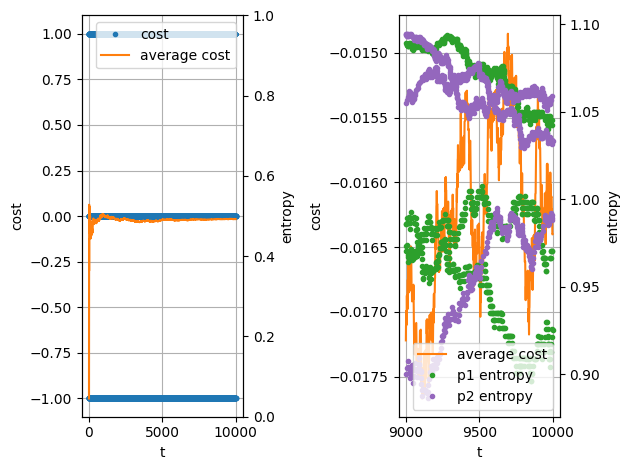

In [36]:
iters=range(M);
average_costs=numpy.divide(numpy.cumsum(costs),numpy.add(range(M),1))
slc=slice(int(.9*M),M)
fig, ax=plt.subplots(1,2)
# Plot costs, average cost, and entropy, from start
ax_twin=ax[0].twinx()
lines=ax[0].plot(iters,costs,'.',label='cost',color='tab:blue')
lines+=ax[0].plot(iters,average_costs,'-',label='average cost',color='tab:orange')
#lines+=ax_twin.plot(iters,player1_entropy,'-',label='p1 entropy',color='tab:green')
#lines+=ax_twin.plot(iters,player2_entropy,'-',label='p2 entropy',color='tab:purple')
ax[0].grid()
ax[0].set_xlabel('t')
ax[0].set_ylabel('cost')
ax_twin.set_ylabel('entropy')
leg=ax_twin.legend(lines,[line.get_label() for line in lines])
#  Plot costs, average cost, and entropy, skipping start
ax_twin=ax[1].twinx()
lines=ax[1].plot(iters[slc],average_costs[slc],'-',label='average cost',color='tab:orange')
lines+=ax_twin.plot(iters[slc],player1_entropy[slc],'.',label='p1 entropy',color='tab:green')
lines+=ax_twin.plot(iters[slc],player2_entropy[slc],'.',label='p2 entropy',color='tab:purple')
leg=ax_twin.legend(lines,[line.get_label() for line in lines])
ax[1].grid()
ax[1].set_xlabel('t')
ax[1].set_ylabel('cost')
ax_twin.set_ylabel('entropy')
fig.tight_layout()
plt.show();